## 1. Importing Libraries
* This section imports all the necessary Python libraries for data manipulation visualization,
* machine learning, and model persistence.

In [8]:
# AI_Predictive_System/notebooks/model_training.ipynb

import pandas as pd # Used for data manipulation and analysis, especially with DataFrames.
import numpy as np # Used for numerical operations, especially with arrays and mathematical functions.
import matplotlib.pyplot as plt # A plotting library used for creating static, interactive, and animated visualizations.
import seaborn as sns # Built on Matplotlib, provides a high-level interface for drawing attractive statistical graphics.

# scikit-learn is the primary library for machine learning algorithms.
from sklearn.model_selection import train_test_split, GridSearchCV
    # train_test_split: Divides the dataset into training and testing subsets.
    # GridSearchCV: Performs an exhaustive search over specified parameter values for an estimator.
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
    # StandardScaler: Standardizes features by removing the mean and scaling to unit variance.
    # OneHotEncoder: Converts categorical (non-numeric) data into a numerical format that ML algorithms can understand.
    # LabelEncoder: Encodes categorical labels into numerical labels (0 to n-1). Used here for temporary visualization.
from sklearn.impute import SimpleImputer # For handling missing values
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
    # Metrics used to evaluate the performance of the classification model.
    # accuracy_score: Proportion of correctly classified instances.
    # precision_score: Proportion of true positive predictions among all positive predictions.
    # recall_score: Proportion of true positive predictions among all actual positive instances (sensitivity).
    # f1_score: Harmonic mean of precision and recall.
    # confusion_matrix: A table used to describe the performance of a classification model.
    # classification_report: Builds a text report showing the main classification metrics.
import joblib # For saving the model



## --- Phase 2: Data Preprocessing and EDA ---
* This phase focuses on loading the raw data, inspecting it, cleaning it, and preparing it
* for model training. It also includes Exploratory Data Analysis (EDA) to understand the data's characteristics.

* Load CSV - Make sure heart_disease_uci.csv is in the data/ folder
* This block attempts to read the specified CSV file into a pandas DataFrame.
* It includes error handling in case the file is not found.

In [9]:

try:
    df = pd.read_csv('../data/heart_disease_uci.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: heart_disease_uci.csv not found. Please ensure it's in the 'data/' directory.")
    exit()

print("\nDataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing Values (before handling):")
print(df.isnull().sum())


Dataset loaded successfully.

Dataset Head:
   id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal

## --- Data Cleaning and Initial Transformation ---
* This section performs specific cleaning steps tailored to the 'heart_disease_uci.csv' dataset,
* addressing its unique characteristics like 'id', 'dataset', 'num' column, and '?' for missing values.

* Drop 'id' and 'dataset' columns as they are not features for prediction
* 'id' is a unique identifier, not a predictive feature.
* 'dataset' indicates the source clinic, which might cause data leakage if used as a feature,
* and is not a clinical feature relevant to the patient's condition.

In [10]:
# --- Data Cleaning and Initial Transformation ---

# Drop 'id' and 'dataset' columns as they are not features for prediction
df = df.drop(['id', 'dataset'], axis=1)

# Rename 'num' column to 'target' for consistency with project requirements
# This dataset's 'num' column indicates stages (0 to 4).
# For binary classification (heart disease or not), we'll convert num > 0 to 1.
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop('num', axis=1) # Drop the original 'num' column

# Handle inconsistent '?' values by replacing them with NaN
# This dataset often uses '?' for missing values, which pandas reads as strings
df.replace('?', np.nan, inplace=True)

# Convert boolean/object columns that should be numerical to appropriate types
# 'fbs' is 'True'/'False', 'exang' is 'True'/'False'
# Convert 'sex' from 'Male'/'Female' to 1/0
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['fbs'] = df['fbs'].map({'True': 1, 'False': 0}).astype(float) # Convert to float for imputation if needed
df['exang'] = df['exang'].map({'True': 1, 'False': 0}).astype(float) # Convert to float for imputation if needed

# Convert remaining object columns to numerical or handle them as categorical for OneHotEncoding
# 'cp', 'restecg', 'slope', 'thal' are categorical
# 'ca' is numerical but has missing values and possibly non-integer '?' values, so convert to float
# `errors='coerce'` is crucial: if a value cannot be converted, it will be replaced by NaN.
df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
df['oldpeak'] = pd.to_numeric(df['oldpeak'], errors='coerce') # Ensure oldpeak is numeric

print("\nMissing Values (after initial cleaning):")
print(df.isnull().sum())
# Recalculates missing values after replacing '?' and initial type conversions.
# This shows the actual number of NaNs for each column that the imputer needs to handle.

print("\nDataset Info (after initial cleaning):")
df.info() # Provides an updated summary, showing new data types after transformations.

print("\nDescriptive Statistics (after initial cleaning):")
print(df.describe())
# Generates descriptive statistics (mean, std, min, max, quartiles) for numerical columns.
# This helps understand the distribution and range of numerical features after cleaning.

# Separate features (X) and target (y)
X = df.drop('target', axis=1) # Creates DataFrame 'X' containing all columns except 'target' (features).
y = df['target'] # Creates Series 'y' containing only the 'target' column (labels).




Missing Values (after initial cleaning):
age           0
sex           0
cp            0
trestbps     59
chol         30
fbs         920
restecg       2
thalch       55
exang       920
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

Dataset Info (after initial cleaning):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   cp        920 non-null    object 
 3   trestbps  861 non-null    float64
 4   chol      890 non-null    float64
 5   fbs       0 non-null      float64
 6   restecg   918 non-null    object 
 7   thalch    865 non-null    float64
 8   exang     0 non-null      float64
 9   oldpeak   858 non-null    float64
 10  slope     611 non-null    object 
 11  ca        309 non-null    float64
 12  thal      434 non-null   


Correlation Matrix (Note: Categorical features are label encoded for visualization):


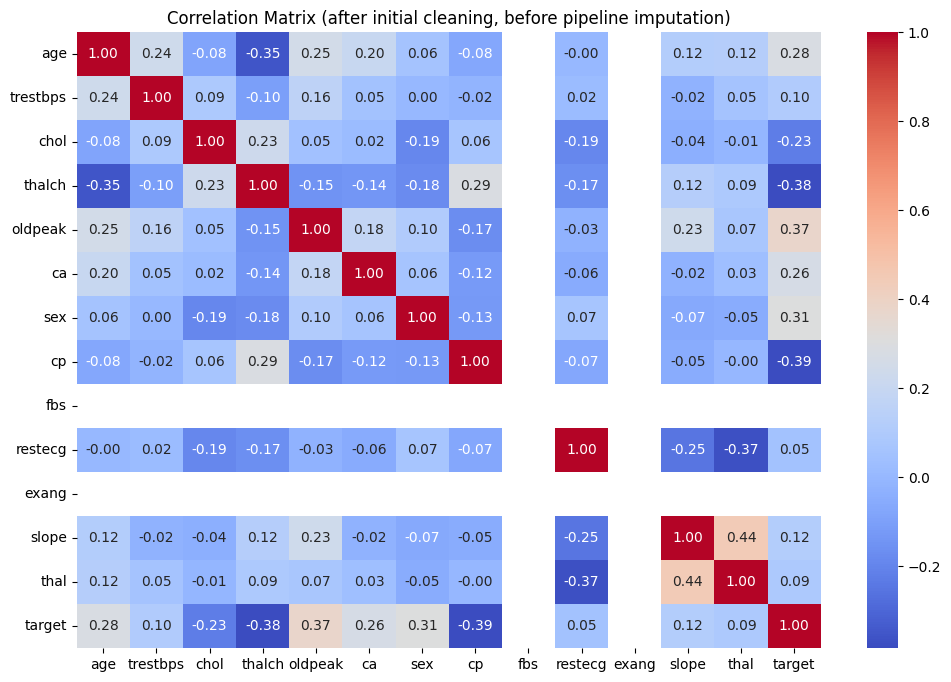

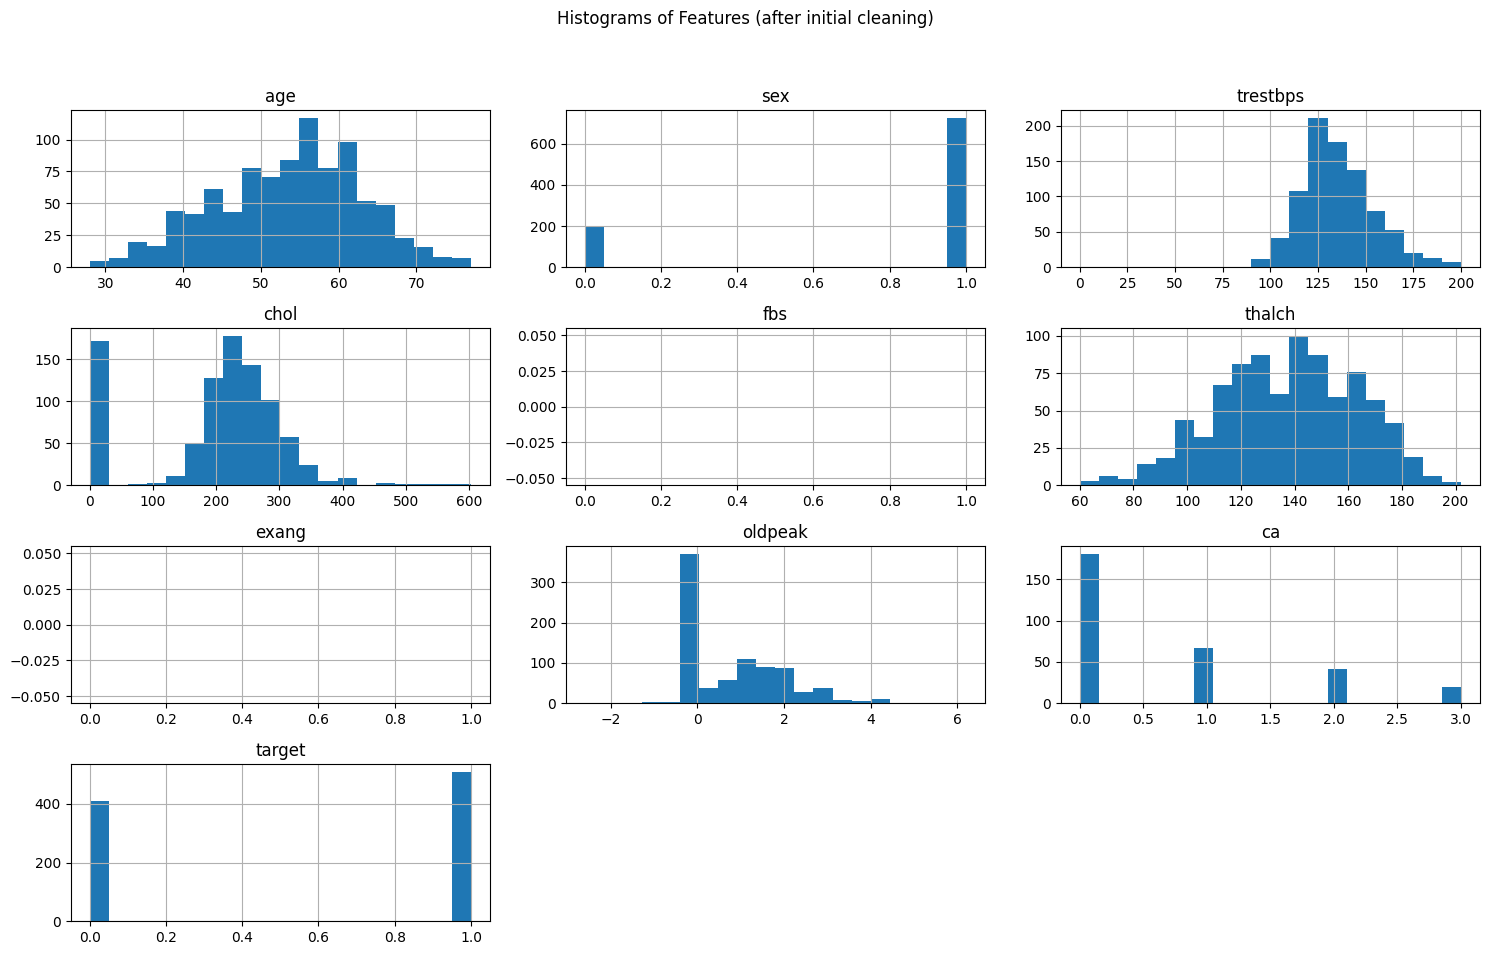

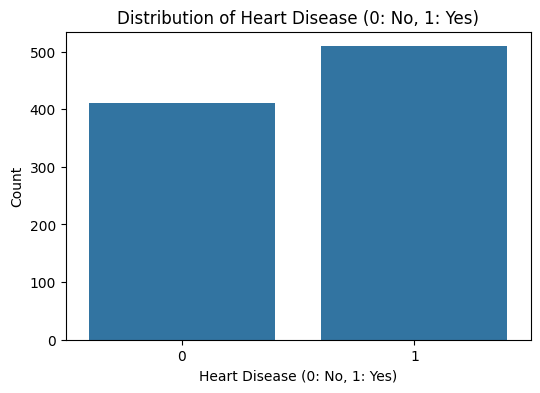

Count of target 0: 411
Count of target 1: 509


In [11]:
# Identify categorical and numerical features for preprocessing
# Re-evaluate based on the cleaned dataset
# Ensure 'ca' and 'oldpeak' are treated as numerical since they were coerced to float
numerical_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca'] # 'ca' is often treated as categorical, but here it's numerical after cleaning
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# --- EDA after initial cleaning (before imputation for visuals) ---
# This section generates visualizations after the initial data types are correct,
# but before applying the full imputation/scaling pipeline, to get a raw sense of the data.

# Temporarily fill numerical NaNs with mean for correlation matrix to work
# `df.corr()` requires all columns to be numerical. Since some numerical columns still have NaNs,
# they need to be temporarily filled *just for this visualization*.
# This temporary filling does NOT affect the actual data used by the model pipeline, as the pipeline
# will handle imputation separately.
df_numeric_for_corr = df[numerical_features].fillna(df[numerical_features].mean())

# Convert categorical data for correlation matrix visualization using LabelEncoder or similar
# `sns.heatmap` also needs all data to be numerical. For categorical columns, we use LabelEncoder
# to convert them to numbers (0, 1, 2...). This is a quick way for visualization but not suitable for
# direct model training (OneHotEncoding is preferred for that).
temp_df = df_numeric_for_corr.copy()
for col in categorical_features:
    # Only encode if the column exists in the current df for heatmap
    if col in df.columns:
        le = LabelEncoder()
        # Handle potential NaNs in categorical columns during temporary encoding:
        # Converts column to string to handle any remaining NaNs as string 'nan', then fills them
        # with a placeholder category 'Missing_Category' before encoding.
        temp_df[col] = df[col].astype(str).apply(lambda x: x if x != 'nan' else None) # Handle NaNs
        temp_df[col] = le.fit_transform(temp_df[col].fillna('Missing_Category')) # Impute missing for encoding
        # You might also want to fill missing categorical values with mode before this for better representation

print("\nCorrelation Matrix (Note: Categorical features are label encoded for visualization):")
plt.figure(figsize=(12, 8))
# Combine temp_df with the target column (which is already numerical 0/1)
full_temp_df = pd.concat([temp_df, df['target']], axis=1)
sns.heatmap(full_temp_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
    # `full_temp_df.corr(numeric_only=True)` calculates the pairwise correlation of columns, ignoring non-numeric ones.
    # `annot=True`: Displays the correlation values on the heatmap.
    # `cmap='coolwarm'`: Color map (red for negative, blue for positive correlation).
    # `fmt=".2f"`: Formats the annotation values to two decimal places.
plt.title('Correlation Matrix (after initial cleaning, before pipeline imputation)')
plt.show()

# Histograms for numerical features (after initial cleaning)
# Histograms show the distribution of individual numerical features.
df.hist(figsize=(15, 10), bins=20)

# Creates a grid of histograms for all numerical columns in `df`.
# `bins=20` sets the number of bins in each histogram.
plt.suptitle('Histograms of Features (after initial cleaning)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Distribution of target variable (now correctly named 'target' and binary)
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Distribution of Heart Disease (0: No, 1: Yes)')
plt.xlabel('Heart Disease (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

print(f"Count of target 0: {df['target'].value_counts()[0]}")
print(f"Count of target 1: {df['target'].value_counts()[1]}")


## --- Phase 3: Model Development ---
* This phase involves defining the data preprocessing steps within a pipeline, splitting the data,
* selecting and training a model, tuning its hyperparameters, and evaluating its performance.

* Create preprocessing pipelines for numerical and categorical features
* These pipelines define how different types of features will be transformed.

* Numerical transformer pipeline:

In [12]:
# --- Phase 3: Model Development ---

# Create preprocessing pipelines for numerical and categorical features
# Use SimpleImputer to handle missing values
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values with mean
    ('scaler', StandardScaler()) # Normalize/scale numerical features
])

# Categorical transformer pipeline:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # Encode categorical data
])

# Create a preprocessor using ColumnTransformer
# ColumnTransformer applies different transformers to different columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns that are not in num or cat (e.g., if there were any left)
)

# Split data into Train/Test sets (80/20)
# Use the X and y defined after initial cleaning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    # `X`: Features DataFrame.
    # `y`: Target Series.
    # `test_size=0.2`: 20% of the data will be used for the test set, 80% for training.
    # `random_state=42`: Ensures reproducibility. Running the code multiple times will result in the same split.
    # `stratify=y`: Ensures that the proportion of target classes (0 and 1) is the same in both training and test sets
    #               as it is in the original dataset. This is crucial for imbalanced datasets.


print(f"\nTraining data shape: {X_train.shape}") # Prints the dimensions (rows, columns) of the training features.
print(f"Testing data shape: {X_test.shape}") # Prints the dimensions of the testing features.

# Model Chosen: Random Forest Classifier
# Random Forest is an ensemble learning method that builds multiple decision trees during training
# and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees.
# It's robust to overfitting and works well with various data types.

# Create a pipeline that first preprocesses and then applies the model
# A Pipeline sequentially applies a list of transforms and a final estimator.
# This ensures that the same preprocessing steps are applied consistently to both training and new data.
# It also prevents data leakage from the test set into the training data during preprocessing.
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(random_state=42))])




Training data shape: (736, 13)
Testing data shape: (184, 13)



Starting GridSearchCV for Hyperparameter Tuning...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters found: {'classifier__max_depth': 6, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation accuracy: 0.8247

Model Evaluation on Test Set:
Accuracy: 0.8370
Precision: 0.8158
Recall: 0.9118
F1-score: 0.8611

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        82
           1       0.82      0.91      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184


Confusion Matrix:


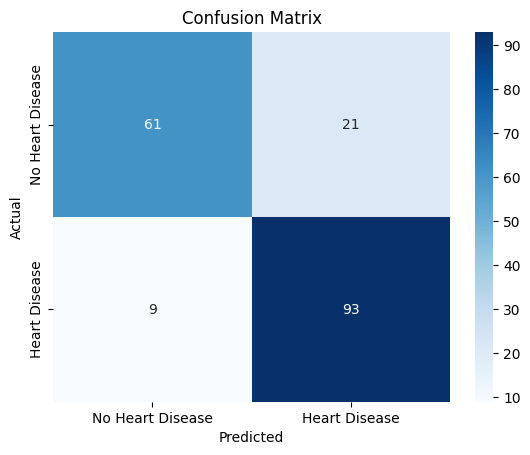


Trained model saved to ../model/heart_model.pkl

Model Training and Evaluation Complete.


In [13]:
# Hyperparameter tuning via GridSearchCV
# Hyperparameter tuning is the process of finding the best set of hyperparameters for a model
# to achieve optimal performance. GridSearchCV exhaustively searches all combinations.
# Define parameter grid for RandomForestClassifier
param_grid = {
    'classifier__n_estimators': [100, 200], # Reduced for faster execution in initial testing
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': [4, 6, None], # Reduced options
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

print("\nStarting GridSearchCV for Hyperparameter Tuning...")
grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
    # `model_pipeline`: The estimator to tune.
    # `param_grid`: The dictionary of hyperparameters to search.
    # `cv=5`: Performs 5-fold cross-validation. The training data is split into 5 parts; the model is trained on 4 and tested on 1,
    #         and this process is repeated 5 times, rotating the test fold.
    # `verbose=1`: Controls the verbosity of the output (how much information is printed during fitting).
    # `n_jobs=-1`: Uses all available CPU cores for parallel processing, speeding up the search.
    # `scoring='accuracy'`: The metric used to evaluate model performance for selecting the best parameters.
grid_search.fit(X_train, y_train) # Fit the grid search on the training data

print(f"\nBest Parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_
# Retrieves the model (the entire pipeline with the best parameters) that performed best during GridSearchCV.
# This `best_model` is what will be used for final evaluation and deployment.

# Evaluate the best model on the test set
# This assesses the trained model's performance on the completely unseen 'X_test' data.
y_pred = best_model.predict(X_test)

# Evaluation Metrics: Accuracy, Precision, Recall, F1-score
# These metrics provide a comprehensive view of the model's performance.
accuracy = accuracy_score(y_test, y_pred) # Calculates the proportion of correctly classified instances.
precision = precision_score(y_test, y_pred) # Calculates precision for the positive class (class 1, heart disease).
recall = recall_score(y_test, y_pred) # Calculates recall for the positive class (class 1).
f1 = f1_score(y_test, y_pred) # Calculates F1-score for the positive class (class 1).   

print(f"\nModel Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}") # Prints the calculated accuracy.
print(f"Precision: {precision:.4f}") # Prints the calculated precision.
print(f"Recall: {recall:.4f}") # Prints the calculated recall.  
print(f"F1-score: {f1:.4f}") # Prints the calculated F1-score.

print("\nClassification Report:")
print(classification_report(y_test, y_pred)) # Generates a detailed report including precision, recall, F1-score,
                                           # and support for each class (0 and 1), and overall averages.

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred) # Computes the confusion matrix, which shows the counts of true positives,
                                     # true negatives, false positives, and false negatives.
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
    # `annot=True`: Displays the values in each cell.
    # `fmt='d'`: Formats the annotations as integers.
    # `cmap='Blues'`: Uses a blue color scheme.
plt.xlabel('Predicted') # Labels the x-axis.
plt.ylabel('Actual') # Labels the y-axis.
plt.title('Confusion Matrix') # Sets the title of the plot.
plt.show() # Displays the confusion matrix plot.

# Save model as heart_model.pkl
# This step is crucial for deploying the model. The trained model (the entire pipeline including preprocessing steps)
# is saved to a file, which can then be loaded by the Flask application for making predictions.
model_save_path = '../model/heart_model.pkl' # Defines the path where the model will be saved.
joblib.dump(best_model, model_save_path) # Uses joblib to serialize (save) the 'best_model' object to the specified file.
print(f"\nTrained model saved to {model_save_path}") # Confirmation message.

print("\nModel Training and Evaluation Complete.") # Final message indicating completion.